In [275]:
import nflreadpy as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [ ]:
schedule = nfl.load_schedules([2021, 2022, 2023, 2024, 2025]).to_pandas() #Import schedules and game info for 2021-2025 seasons
games = schedule[
    (schedule['game_type']=='REG') & #include only regular season games
    (schedule['home_score'].notna())&
    (schedule['away_score'].notna())
].copy()

In [203]:
games['home_win'] = (games['home_score'] > games['away_score']).astype(int) #Home win variable
games

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,home_win
0,2021_01_DAL_TB,2021,REG,1,2021-09-09,Thursday,20:20,DAL,29.0,TB,...,00-0033077,00-0019596,Dak Prescott,Tom Brady,Mike McCarthy,Bruce Arians,Shawn Hochuli,TAM00,Raymond James Stadium,1
1,2021_01_PHI_ATL,2021,REG,1,2021-09-12,Sunday,13:00,PHI,32.0,ATL,...,00-0036389,00-0026143,Jalen Hurts,Matt Ryan,Nick Sirianni,Arthur Smith,Scott Novak,ATL97,Mercedes-Benz Stadium,0
2,2021_01_PIT_BUF,2021,REG,1,2021-09-12,Sunday,13:00,PIT,23.0,BUF,...,00-0022924,00-0034857,Ben Roethlisberger,Josh Allen,Mike Tomlin,Sean McDermott,John Hussey,BUF00,New Era Field,0
3,2021_01_NYJ_CAR,2021,REG,1,2021-09-12,Sunday,13:00,NYJ,14.0,CAR,...,00-0037013,00-0034869,Zach Wilson,Sam Darnold,Robert Saleh,Matt Rhule,Clay Martin,CAR00,Bank of America Stadium,1
4,2021_01_MIN_CIN,2021,REG,1,2021-09-12,Sunday,13:00,MIN,24.0,CIN,...,00-0029604,00-0036442,Kirk Cousins,Joe Burrow,Mike Zimmer,Zac Taylor,Adrian Hill,CIN00,Paul Brown Stadium,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,2025_16_CIN_MIA,2025,REG,16,2025-12-21,Sunday,13:00,CIN,45.0,MIA,...,00-0036442,00-0040234,Joe Burrow,Quinn Ewers,Zac Taylor,Mike McDaniel,John Hussey,MIA00,Hard Rock Stadium,0
1378,2025_16_SF_IND,2025,REG,16,2025-12-22,Monday,20:15,SF,48.0,IND,...,00-0037834,00-0022942,Brock Purdy,Philip Rivers,Kyle Shanahan,Shane Steichen,Ron Torbert,IND00,Lucas Oil Stadium,0
1379,2025_17_DAL_WAS,2025,REG,17,2025-12-25,Thursday,13:00,DAL,30.0,WAS,...,00-0033077,00-0026300,Dak Prescott,Josh Johnson,Brian Schottenheimer,Dan Quinn,Brad Rogers,WAS00,FedExField,0
1380,2025_17_DET_MIN,2025,REG,17,2025-12-25,Thursday,16:30,DET,10.0,MIN,...,00-0033106,00-0040494,Jared Goff,Max Brosmer,Dan Campbell,Kevin O'Connell,Shawn Smith,MIN01,U.S. Bank Stadium,1


In [ ]:
# Load all available team level stats
team_stats = nfl.load_team_stats([2021, 2022, 2023, 2024, 2025]).to_pandas() #load team and game stats for 2021-2025 seasons
team_stats['turnovers_offense'] = (team_stats['passing_interceptions']+ #rows correspond to single game stats
                                 team_stats['sack_fumbles_lost']+
                                 team_stats['rushing_fumbles_lost']+
                                 team_stats['receiving_fumbles_lost']
                                 )
team_stats['turnovers_defense'] = (team_stats['def_interceptions']+
                                 team_stats['def_fumbles'])
team_stats['turnover_margin'] = (team_stats['turnovers_defense']-
                               team_stats['turnovers_offense'])
team_stats['completion_pct'] = (team_stats['completions']/team_stats['attempts'])


In [204]:

team_stats[team_stats['team'] == "NE"]


,season,week,team,season_type,opponent_team,completions,attempts,passing_yards,passing_tds,passing_interceptions,...,sacks_suffered_ewma,rushing_tds_ewma,completion_pct_ewma,turnovers_offense_ewma,turnovers_defense_ewma,turnover_margin_ewma,def_tackles_for_loss_ewma,penalty_yards_ewma,fg_pct_ewma,pat_pct_ewma
21,2021,1,NE,REG,MIA,29,39,281,1,0,...,1.000000,0.000000,0.743590,2.000000,1.000000,-1.000000,4.000000,84.000000,1.000000,1.000000
53,2021,2,NE,REG,NYJ,22,30,186,0,0,...,1.800000,0.800000,0.739487,1.200000,2.200000,1.000000,4.800000,72.000000,1.000000,0.800000
85,2021,3,NE,REG,NO,30,51,270,1,3,...,1.880000,0.480000,0.678986,1.920000,1.320000,-0.600000,4.480000,55.200000,1.000000,0.880000
117,2021,4,NE,REG,TB,33,42,320,2,1,...,2.728000,0.288000,0.721678,1.952000,0.792000,-1.160000,3.088000,63.920000,0.800000,0.928000
149,2021,5,NE,REG,HOU,23,30,231,1,1,...,2.036800,0.572800,0.739673,1.971200,0.475200,-1.496000,3.452800,49.152000,0.880000,0.756800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596,2025,11,NE,REG,NYJ,25,34,281,1,0,...,2.410321,1.553336,0.681018,0.760368,0.497456,-0.262913,4.159215,33.850943,0.821592,0.997279
2624,2025,12,NE,REG,CIN,22,35,294,1,1,...,1.846192,0.932002,0.660039,0.856221,0.698473,-0.157748,2.895529,41.110566,0.892955,0.998367
2655,2025,13,NE,REG,NYG,24,31,282,2,0,...,2.307715,0.559201,0.705701,0.513733,0.419084,-0.094649,3.737318,36.666340,0.855773,0.999020
2715,2025,15,NE,REG,BUF,14,23,155,0,1,...,2.584629,1.935521,0.666899,0.708240,0.651450,-0.056789,4.242391,47.999804,0.913464,0.999412


In [178]:
independent_variables = ['completions',
                       'passing_yards',
                       'passing_tds',
                       'rushing_yards',
                       'sacks_suffered',
                       'rushing_tds',
                       'completion_pct',
                       'turnovers_offense',
                       'turnovers_defense',
                       'turnover_margin',
                       'def_tackles_for_loss',
                       'penalty_yards',
                       'fg_pct',
                       'pat_pct',
                       ]


In [ ]:
for var in independent_variables: #make an exponential weighted mean to favor more recent game stats
    team_stats[f'{var}_ewma'] = team_stats.groupby('team')[var].transform(
        lambda x: x.ewm(alpha=0.4, adjust=False).mean()
    )

#ewma_cols = [f'{col}_ewma' for col in ]

In [280]:
ewma_cols = [f'{col}_ewma' for col in independent_variables]
keep_cols = ['season', 'week', 'team', 'opponent_team'] + ewma_cols
df_filtered=team_stats[keep_cols]

df_filtered.to_csv('df_clean.csv')

In [214]:
home_stats = df_filtered[['season', 'week', 'team'] + ewma_cols].copy()
home_stats.columns = ['season', 'week', 'home_team'] + [f'home_{col}' for col in ewma_cols]

# For away team stats
away_stats = df_filtered[['season', 'week', 'team'] + ewma_cols].copy()
away_stats.columns = ['season', 'week', 'away_team'] + [f'away_{col}' for col in ewma_cols]


In [284]:
games_with_stats=games.merge(
    home_stats,
    on=['season', 'week', 'home_team'],
    how='left'
).merge(
    away_stats,
    on=['season', 'week', 'away_team'],
    how='left'
)
#games_with_stats.to_csv('games_with_stats.csv')

In [285]:
feature_columns = []
for col in ewma_cols:
    diff_col = f'diff_{col}'
    games_with_stats[diff_col] = games_with_stats[f'home_{col}'] - games_with_stats[f'away_{col}']
    feature_columns.append(diff_col)
games_with_stats[feature_columns]

,diff_completions_ewma,diff_passing_yards_ewma,diff_passing_tds_ewma,diff_rushing_yards_ewma,diff_sacks_suffered_ewma,diff_rushing_tds_ewma,diff_completion_pct_ewma,diff_turnovers_offense_ewma,diff_turnovers_defense_ewma,diff_turnover_margin_ewma,diff_def_tackles_for_loss_ewma,diff_penalty_yards_ewma,diff_fg_pct_ewma,diff_pat_pct_ewma
0,-10.000000,-24.000000,1.000000,-8.000000,-1.000000,0.000000,-0.084138,3.000000,-1.000000,-4.000000,2.000000,51.000000,0.400000,0.333333
1,-6.000000,-100.000000,-3.000000,-49.000000,2.000000,-1.000000,-0.171429,0.000000,0.000000,0.000000,-1.000000,10.000000,0.000000,NaN
2,12.000000,82.000000,0.000000,42.000000,1.000000,0.000000,0.025735,1.000000,0.000000,-1.000000,-1.000000,49.000000,0.000000,0.000000
3,4.000000,21.000000,-1.000000,66.000000,-5.000000,1.000000,0.145174,0.000000,1.000000,1.000000,2.000000,8.000000,NaN,NaN
4,-17.000000,-101.000000,0.000000,82.000000,2.000000,0.000000,0.000741,-1.000000,0.000000,1.000000,0.000000,-101.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,-6.673048,-53.561528,-1.819219,35.112649,-0.234364,0.864633,-0.010358,0.641927,-0.595388,-1.237315,0.444385,4.633654,0.002014,-0.013662
1326,-1.978268,-43.333033,-1.840793,-42.808467,0.456408,0.061755,-0.076111,0.221744,-0.106224,-0.327968,1.254502,11.330947,0.123237,-0.023945
1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [286]:
train_data = games_with_stats[games_with_stats['season']< 2025]
test_data=games_with_stats[games_with_stats['season'] == 2025]

test_data.columns


Index(['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday',
       'gametime', 'away_team', 'away_score', 'home_team', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game',
       'roof', 'surface', 'temp', 'wind', 'away_qb_id', 'home_qb_id',
       'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium', 'home_win', 'home_completions_ewma',
       'home_passing_yards_ewma', 'home_passing_tds_ewma',
       'home_rushing_yards_ewma', 'home_sacks_suffered_ewma',
       'home_rushing_tds_ewma', 'home_completion_pct_ewma',
       'home_turnovers_offense_ewma', 'home_turnovers_defense_ewma',
       'home_turnover_margin_ewma', 'home_def_tackles_for_loss_ewma',
       'h

In [229]:
X_train = train_data[feature_columns]
y_train = train_data['home_win']

In [230]:
X_test = test_data[feature_columns]
y_test = test_data['home_win']

In [233]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [234]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=67, max_depth=20, min_samples_split=20)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",20
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [270]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)
top_features = feature_importance.head(10)



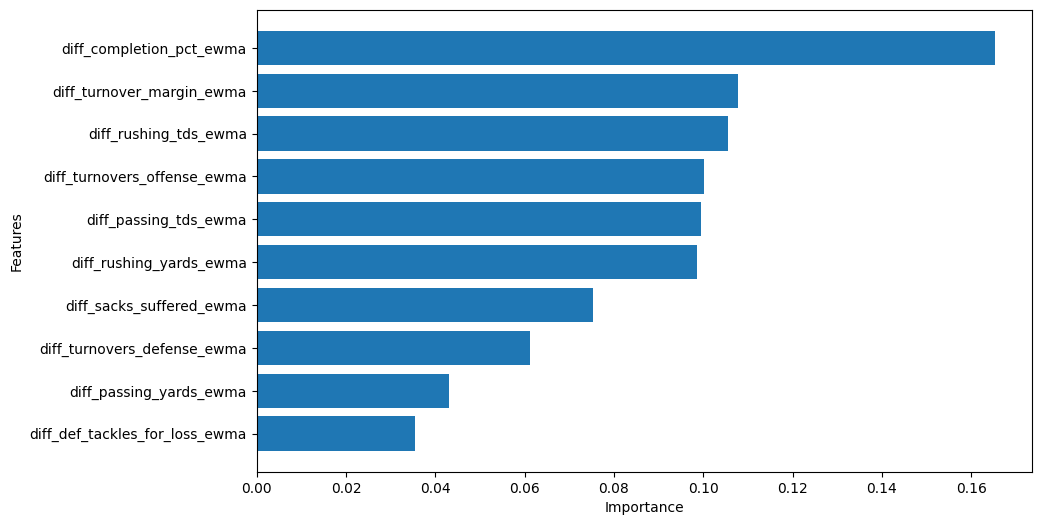

In [272]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [263]:
X_train_selected = train_data[top_features]
X_test_selected = test_data[top_features]

In [274]:
scaler_selected = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)

In [276]:
model = LogisticRegression(random_state=67, max_iter=1000)
model.fit(X_train_scaled, y_train)
lr_all_train = model.score(X_train_scaled, y_train)
lr_all_test = model.score(X_test_scaled, y_test)

# Logistic Regression - Selected Features
model_selected = LogisticRegression(random_state=42, max_iter=1000)
model_selected.fit(X_train_scaled_selected, y_train)
lr_sel_train = model_selected.score(X_train_scaled_selected, y_train)
lr_sel_test = model_selected.score(X_train_scaled_selected, y_test)


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values